{{ prolog }}

# MESMER-X workflow for annual maximum temperatures

In this tutorial we use a conditional distribution to model the dependence of a climate variable on a global predictor using the approach from MESMER-X (Quilquaille et al., [2022]( https://doi.org/10.1029/2022GL099012)). In this example we model annual maximum temperature with a normal distribution with a linear dependence on global mean temperature. 

:::{note}
- We fit annual maximum data (i.e. a block maxima) using a normal distribution. This is not the appropriate distribution for this type of data but is used for illustrative purposes and speed.
- A normal distribution with a linear dependence of the mean on a variable is equivalent to a linear regression with is much faster to use directly. Again, this is only for illustrative purposes.
:::


In [1]:
import pathlib

import filefisher
import matplotlib.pyplot as plt
import xarray as xr

import mesmer
from mesmer.distrib import (
    ConditionalDistribution,
    Expression,
    ProbabilityIntegralTransform,
)

## Calibration

### Configuration

In [2]:
scenario = "ssp585"
target_name = "tasmax"
option_2ndfit = False
save_files = False

In [3]:
THRESHOLD_LAND = 1 / 3
REFERENCE_PERIOD = slice("1850", "1900")

esm = "IPSL-CM6A-LR"

cmip6_data_path = mesmer.example_data.cmip6_ng_path()

### Load and prepare predictor and forcing data

MESMER-X expectes the predictor and forcing data in the same format as MESMER and MESMER-M. First define helper functions to load data from the cmip6-ng example data archive.

:::{caution}
- In the original cmip6-ng archive annual tasmax archive is not the annual maximum temperature (TXx) but the annual mean daily maximum temperature. In MESMER's example data archive the annual maximum is provided.
:::

In [4]:
def find_files(variable, model, scenarios, member=None):

    CMIP_FILEFINDER = filefisher.FileFinder(
        path_pattern=str(cmip6_data_path / "{variable}/{time_res}/{resolution}"),
        file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
    )

    fc_scens_pred = CMIP_FILEFINDER.find_files(
        variable=variable,
        scenario=scenarios,
        model=model,
        member=member,
        resolution="g025",
        time_res="ann",
    )

    # only get the historical members that are also in the future scenarios, but only once
    unique_scen_members = fc_scens_pred.df.member.unique()

    fc_hist_pred = CMIP_FILEFINDER.find_files(
        variable=variable,
        scenario="historical",
        model=model,
        resolution="g025",
        time_res="ann",
        member=unique_scen_members,
    )

    fc_pred = fc_hist_pred.concat(fc_scens_pred)

    return fc_pred

In [5]:
def load_data(fc):
    data = xr.DataTree()

    scenarios = fc.df.scenario.unique().tolist()

    for scen in scenarios:
        # load data for each scenario
        data_scen = []

        for var in fc.df.variable.unique():
            files = fc.search(variable=var, scenario=scen)

            # load all members for a scenario
            members = []
            for fN, meta in files.items():
                time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
                ds = xr.open_dataset(fN, decode_times=time_coder)
                # drop unnecessary variables
                ds = ds.drop_vars(
                    ["height", "time_bnds", "file_qf", "area"], errors="ignore"
                )
                # assign member-ID as coordinate
                ds = ds.assign_coords({"member": meta["member"]})
                members.append(ds)

            # create a Dataset that holds each member along the member dimension
            data_var = xr.concat(members, dim="member")
            data_scen.append(data_var)

        data_scen = xr.merge(data_scen)
        data[scen] = xr.DataTree(data_scen)
    return data

load predictor data

In [6]:
fc_pred = find_files(variable="tas", model=esm, scenarios=scenario, member="r1i1p1f1")
tas = load_data(fc_pred)

In [7]:
# calculate anomalies w.r.t. the reference period
tas_anom = mesmer.anomaly.calc_anomaly(tas, reference_period=REFERENCE_PERIOD)

In [8]:
# calculate global mean
tas_glob_mean = mesmer.weighted.global_mean(tas_anom)

load target data

In [9]:
fc_targ = find_files(
    variable=target_name, model=esm, scenarios=scenario, member="r1i1p1f1"
)
targ_data_orig = load_data(fc_targ)

In [10]:
# calculate anomalies w.r.t. the reference period
targ_data = mesmer.anomaly.calc_anomaly(
    targ_data_orig, reference_period=REFERENCE_PERIOD
)

In [11]:
# mask ocean, Antarctica and stack the gridpoints
def mask_and_stack(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    ds = mesmer.grid.stack_lat_lon(ds, stack_dim="gridpoint")
    return ds


targ_data = mask_and_stack(targ_data, threshold_land=THRESHOLD_LAND)
pred_data = tas_glob_mean.copy()

also create weights, here samples are weighed by the inverse of their density to give rare samples more weight 



In [12]:
weights = mesmer.weighted.get_weights_density(pred_data=pred_data)

pool data along the sample dimension

In [13]:
pooled_pred, pooled_targ, pooled_weights = mesmer.datatree.broadcast_and_pool_scen_ens(
    predictors=pred_data,
    target=targ_data,
    weights=weights,
)

### Define the Expression and ConditionalDistribution

The `Expression` defines the used distribution and the covariate structure and needs to be created as a string and has the following elements:

- _distribution_: name of the desired distribution as written in _[scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions)_
- _parameters_: the parameters of the distribution as written in scipy (e.g. `loc`, `scale`, ...)
- _predictors_: predictors that the distribution will be conditional on, must be written as variable in python and surrounded by `__` (e.g. ``__tas__``)
- _coefficients_: of the predictors and parameters, must be named `c1`, `c2`, ..., `c9`.
- _mathematical operations_: mathematical operations for the covariates are written as python code. Only functions from numpy (``np.*``) are supported.

Thus for the normal distribution with a linear dependence on global mean temperature (_tas_) this looks as follows:


In [14]:
expr = "norm(loc=c1 + c2 * __tas__, scale=c3)"

expr_name = "expr1"
expression_fit = Expression(expr, expr_name, boundaries_params={}, boundaries_coeffs={})

We then pass the `Expression` to the `ConditionalDistribution` class, which finds the best estimate of the coefficients for given climate model data.

In [15]:
distrib = ConditionalDistribution(expression=expression_fit)

### Fit conditional distribution

Fitting data to arbitrary distributions and covariate structures is a challenging feat - `find_first_guess` uses a multi-step approach to find an inital value for each coefficient:

In [16]:
# find first guess
coeffs_fg = distrib.find_first_guess(
    predictors=pooled_pred,
    target=pooled_targ.tasmax,
    weights=pooled_weights.weights,
)
coeffs_fg

<xarray.Dataset> Size: 5kB
Dimensions:  (gridpoint: 118)
Coordinates:
    lat      (gridpoint) float64 944B -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
    lon      (gridpoint) float64 944B 288.0 288.0 18.0 ... 306.0 324.0 342.0
Dimensions without coordinates: gridpoint
Data variables:
    c1       (gridpoint) float64 944B 0.09746 0.2875 -0.02389 ... 0.0123 -1.409
    c2       (gridpoint) float64 944B 0.9826 1.094 0.7826 ... 0.6549 2.213
    c3       (gridpoint) float64 944B 1.408 1.2 0.727 ... 0.6723 1.002 1.725

The first guess can then be refined by fitting the data using the negative log likelihood as optimization criteria:

In [17]:
# training the conditional distribution
# first round
distrib.fit(
    predictors=pooled_pred,
    target=pooled_targ.tasmax,
    weights=pooled_weights.weights,
    first_guess=coeffs_fg,
)
transform_coeffs = distrib.coefficients

If desired a second round of fit can be done. This approach first calculates a weighted mean of all coefficients in the vicinity of each gridpoint. The weights are inverse to the distance and given by the Gaspari-Cohn function. Please double check if the second round improves your fit.

In [18]:
# second round if necessary
if option_2ndfit:
    transform_coeffs = distrib.fit(
        predictors=pooled_pred,
        target=pooled_targ.tasmax,
        first_guess=transform_coeffs,
        weights=pooled_weights.weights,
        sample_dim="sample",
        smooth_coeffs=True,
        r_gasparicohn=500,
    )

transform_coeffs

<xarray.Dataset> Size: 5kB
Dimensions:  (gridpoint: 118)
Coordinates:
    lat      (gridpoint) float64 944B -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
    lon      (gridpoint) float64 944B 288.0 288.0 18.0 ... 306.0 324.0 342.0
Dimensions without coordinates: gridpoint
Data variables:
    c1       (gridpoint) float64 944B 0.09746 0.2875 -0.02389 ... 0.0123 -1.409
    c2       (gridpoint) float64 944B 0.9826 1.094 0.7826 ... 0.6549 2.213
    c3       (gridpoint) float64 944B 1.408 1.2 0.727 ... 0.6722 1.002 1.725
Attributes:
    expression_name:  expr1
    expression:       norm(loc=c1 + c2 * __tas__, scale=c3)

### Transform to standard normal distribution

After fitting the coefficients the original data is transformed to a standard normal distribution, also removing the fitted linear trend:

In [19]:
# probability integral transform on non-stacked data for AR(1) process
target_expression = Expression("norm(loc=0, scale=1)", "normal_dist")

pit = ProbabilityIntegralTransform(
    distrib_orig=distrib,
    distrib_targ=ConditionalDistribution(target_expression),
)
transf_target = pit.transform(
    data=targ_data, target_name=target_name, preds_orig=pred_data, preds_targ=None
)

### Local variability

The resulting residuals constitute the local variability and are now treated the same way as in MESMER by fitting a local AR(1) process with a spatially correlated noise term.

In [21]:
# training of auto-regression with spatially correlated innovations
local_ar_params = mesmer.stats.fit_auto_regression_scen_ens(
    transf_target,
    ens_dim="member",
    dim="time",
    lags=1,
)

# estimate covariance matrix
# prep distance matrix
geodist = mesmer.geospatial.geodist_exact(
    lon=targ_data["historical"].lon, lat=targ_data["historical"].lat
)
# prep localizer
localisation_radii = range(3_500, 15_001, 250)
phi_gc_localizer = mesmer.stats.gaspari_cohn_correlation_matrices(
    geodist=geodist, localisation_radii=localisation_radii
)

pooled_transf_target = mesmer.datatree.pool_scen_ens(transf_target)


localized_ecov = mesmer.stats.find_localized_empirical_covariance(
    data=pooled_transf_target[target_name],
    weights=pooled_weights.weights.squeeze(),
    localizer=phi_gc_localizer,
    dim="sample",
    k_folds=30,
)

localized_ecov["localized_covariance_adjusted"] = mesmer.stats.adjust_covariance_ar1(
    localized_ecov.localized_covariance, local_ar_params.coeffs
)

Potentially save the params:

In [22]:
test_path = pathlib.Path("./output/")

file_end = f"{target_name}_{expr_name}_{esm}_{scenario}"
distrib_file = test_path / "distrib" / f"params_transform_distrib_{file_end}.nc"
local_ar_file = test_path / "local_variability" / f"params_local_AR_{file_end}.nc"
localized_ecov_file = (
    test_path / "local_variability" / f"params_localized_ecov_{file_end}.nc"
)

if save_files:
    # save the parameters
    transform_coeffs.to_netcdf(distrib_file)
    local_ar_params.to_netcdf(local_ar_file)
    localized_ecov.to_netcdf(localized_ecov_file)

## Make emulations

To generate emulations the workflow of the calibration is reversed, using the estimated parameters from above. Here, we use the same local annual mean temperatures to force the emulations, but temperatures from other models, scenarios, ensemble members or emulated annual local temperatures can be used as well.

### Configuration


In [23]:
# set some configuration parameters
n_realizations = 3
seed = 121638161038369005437100875176885634488
buffer = 10
esm = "IPSL-CM6A-LR"

targ_var = "tasmax"

Where the seed is random but constant (for reporducibility) and was created using

```python
import secrets

secrets.randbits(64)
```

### Load predictor data

In contrast to above we concatenate the historical simulations and the projection.

In [24]:
cmip6_data_path = mesmer.example_data.cmip6_ng_path()

# load predictor data
path_tas = cmip6_data_path / "tas" / "ann" / "g025"

fN_hist = path_tas / f"tas_ann_{esm}_historical_r1i1p1f1_g025.nc"
fN_ssp585 = path_tas / f"tas_ann_{esm}_ssp585_r1i1p1f1_g025.nc"

time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
tas_hist = xr.open_dataset(fN_hist, decode_times=time_coder).drop_vars(
    ["height", "file_qf", "time_bnds"]
)
tas_ssp585 = xr.open_dataset(fN_ssp585, decode_times=time_coder).drop_vars(
    ["height", "file_qf", "time_bnds"]
)

# make global mean
# global_mean_dt = map_over_datasets(mesmer.weighted.global_mean)
tas_glob_mean_hist = mesmer.weighted.global_mean(tas_hist)
tas_glob_mean_ssp585 = mesmer.weighted.global_mean(tas_ssp585)

# concat
predictor = xr.concat([tas_glob_mean_hist, tas_glob_mean_ssp585], dim="time")

predictor = predictor - predictor.sel(time=REFERENCE_PERIOD).mean("time")


time = predictor.time

### Load parameters

This is skipped here because they are still defined from the calibration above.

In [25]:
# load data
# test_path = test_data_root_dir / "output" / targ_var / "one_scen_one_ens"

# load the parameters
# PARAM_FILEFINDER = FileFinder(
#     path_pattern=test_path / "test-params/{module}/",
#     file_pattern="params_{module}_{targ_var}_{expr_name}_{esm}_{scen}.nc",
# )

# distrib_file = PARAM_FILEFINDER.find_single_file(
#     module="distrib",
#     targ_var=targ_var,
#     expr_name=expr_name,
#     esm=esm,
#     scen=scenario,
# ).paths.pop()
# local_ar_file = PARAM_FILEFINDER.find_single_file(
#     module="local_trends",
#     targ_var=targ_var,
#     expr_name=expr_name,
#     esm=esm,
#     scen=scenario,
# ).paths.pop()
# localized_ecov_file = PARAM_FILEFINDER.find_single_file(
#     module="local_variability",
#     targ_var=targ_var,
#     expr_name=expr_name,
#     esm=esm,
#     scen=scenario,
# ).paths.pop()


# transform_coeffs = xr.open_dataset(distrib_file)

# local_ar_params = xr.open_dataset(local_ar_file)

# localized_ecov = xr.open_dataset(localized_ecov_file)

### Create temporally and spatially corelated samples

In [26]:
# generate realizations based on the auto-regression with spatially correlated innovations
transf_emus = mesmer.stats.draw_auto_regression_correlated(
    local_ar_params,
    localized_ecov.localized_covariance_adjusted,
    time=time,
    realisation=n_realizations,
    seed=seed,
    buffer=buffer,
)
transf_emus = transf_emus.rename({"samples": targ_var})

### Transform samples back to the conditional distribution

Initialize the conditional distribution with the calibrated values and the expression:

In [27]:
distrib_orig = ConditionalDistribution.from_dataset(transform_coeffs)

define a standard normal distribution and the probability integral transform:

In [28]:
# back-transform the realizations
expr_tranf = Expression("norm(loc=0, scale=1)", "standard_normal")
distrib_transf = ConditionalDistribution(expr_tranf)

back_pit = ProbabilityIntegralTransform(
    distrib_orig=distrib_transf,
    distrib_targ=distrib_orig,
)

and fially back-transform the realizations

In [29]:
emus = back_pit.transform(
    data=transf_emus, target_name=targ_var, preds_orig=None, preds_targ=predictor
)

### Illustration

Text(0.5, 1.0, 'Training data and emulations at random grid point')

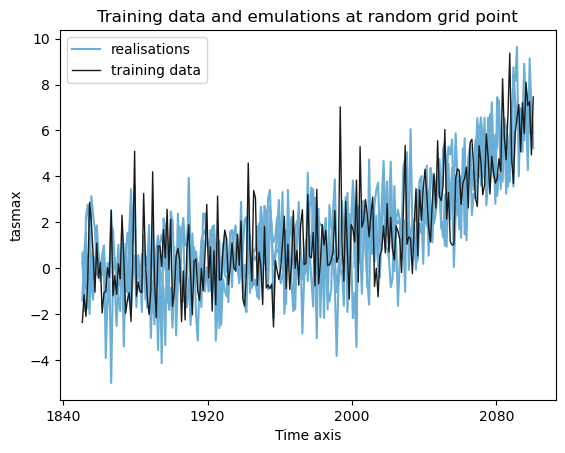

In [30]:
gridpoint = 0


f, ax = plt.subplots()

emus.tasmax.isel(gridpoint=gridpoint).plot.line(
    ax=ax, x="time", color="#6baed6", add_legend=False
)

ax.plot([], [], label="realisations", color="#6baed6")

pooled_targ.tasmax.isel(gridpoint=gridpoint).plot(
    ax=ax, x="time", color="0.1", label="training data", lw=1
)


ax.legend()

ax.set_title("Training data and emulations at random grid point")